# Assignment 2

## Global imports

In [1]:
import shap
import pickle

import numpy as np
import pandas as pd

import tensorflow as tf

from keras.models import Sequential
from keras import layers
from keras import losses
from keras.layers import Dense

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
import glob
import math
import pathlib
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

import eli5
from eli5.sklearn import PermutationImportance

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVR
from sklearn.svm import LinearSVR

from sklearn.metrics import mean_squared_error

/Users/tilmankerl/Documents/UNI/01_WS22/AI Clima/assignment/02/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from climateai.config import *
from climateai.processing.process import Process
from climateai.processing.data_loading import DataLoader
from climateai.processing.sklearn_feature_importance import plot_sk_feature_importance

## Data Loading and Processing

In [3]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
dl = DataLoader()
full_df = dl.load()

X_train, X_test, y_train, y_test, X_wins_train, X_wins_test, X_scaled_train, X_scaled_test = Process.split_data(full_df)

100%|██████████| 100/100 [00:01<00:00, 83.46it/s]


In [5]:
rmse_dict = {}

## All Models

### Neural Network

In [6]:
from climateai.models.neural_net import NeuralNet

#### Training

In [7]:
nn = NeuralNet()

In [8]:
# nn.train(X_scaled_train, y_train)
if not nn.load_model():
    nn.train(X_scaled_train, y_train)

#### Evaluation

In [9]:
rmse_dict["nn"] = nn.evaluate(X_scaled_test, y_test)

  143/13354 [..............................] - ETA: 4s - loss: 6.3615 - precision: 0.9510 - auc: 0.8495   

2023-01-10 21:25:49.979244: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13354/13354 [==============================] - 4s 311us/step - loss: 10.7232 - precision: 0.9635 - auc: 0.8868
RMSE:  3.2746324929940402


#### Feature Importance

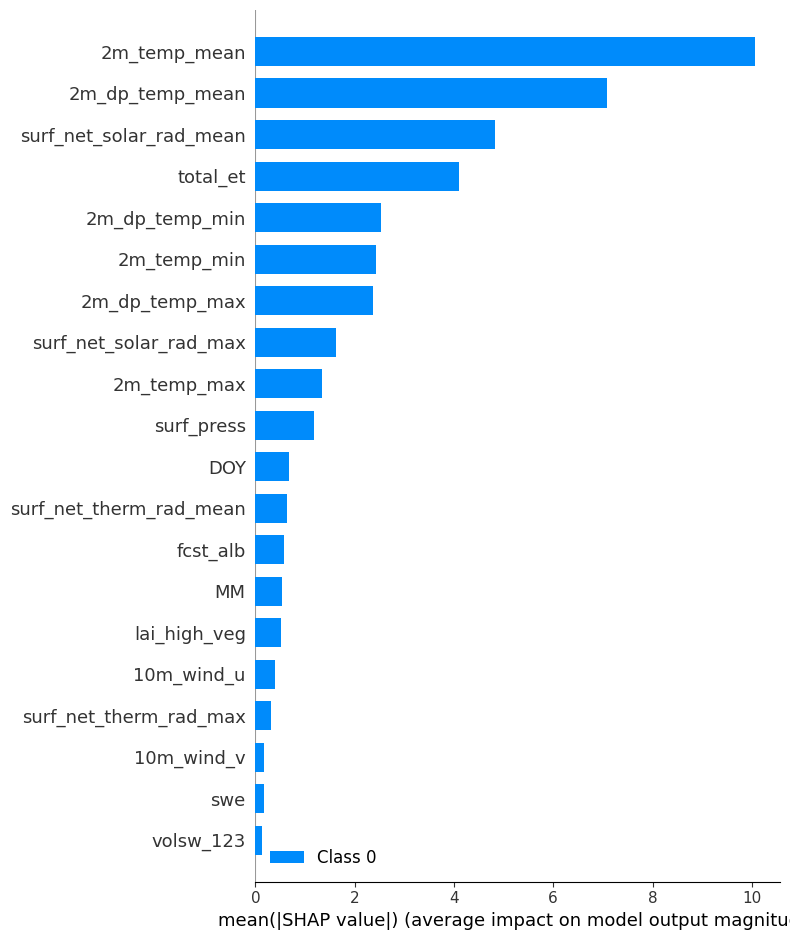

In [10]:
nn.inspect_feature_importance(X_scaled_test, X_test.columns)

### Deep Neural Network

In [11]:
from climateai.models.deep_neural_net import DeepNeuralNet

#### Training

In [12]:
dnn = DeepNeuralNet()

In [13]:
# nn.train(X_scaled_train, y_train)
if not dnn.load_model():
    dnn.train(X_scaled_train, y_train)

#### Evaluation

In [14]:
rmse_dict["dnn"] = dnn.evaluate(X_scaled_test, y_test)

13354/13354 [==============================] - 4s 323us/step - loss: 13.1684 - precision: 0.9814 - auc: 0.8679
RMSE:  3.6288232044453603


#### Feature Importance

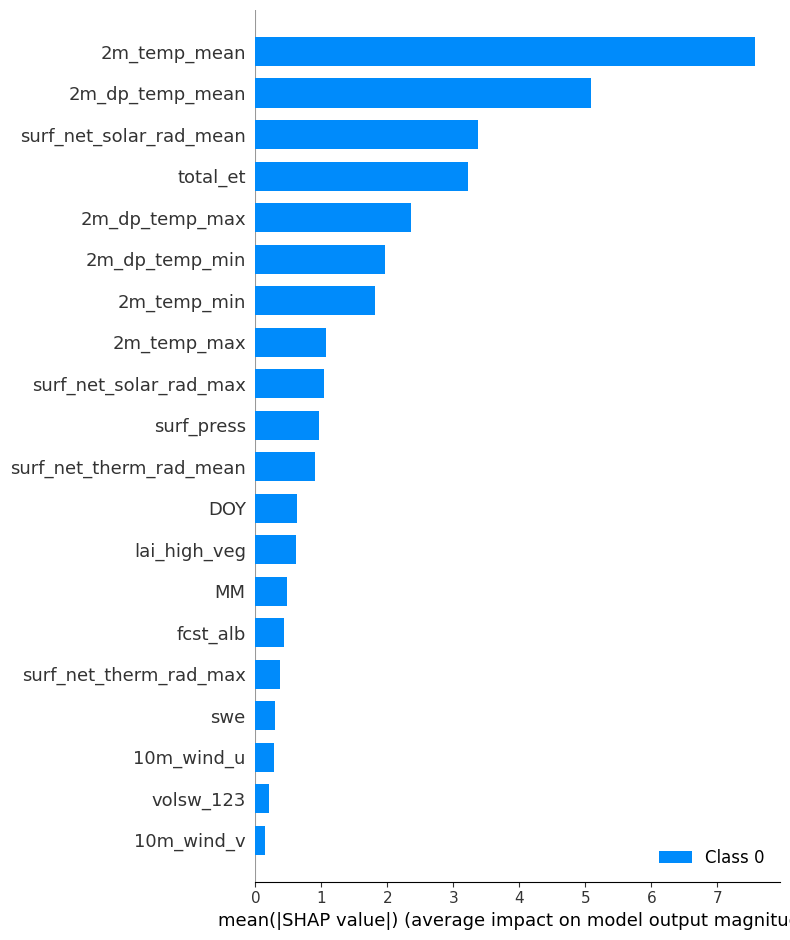

In [15]:
dnn.inspect_feature_importance(X_scaled_test, X_test.columns)

### Random Forrest Regressor

#### Training

In [16]:
# Create a Random Forest Regressor
regressor_rf = RandomForestRegressor(
    n_estimators = 10,
    random_state = SEED
)

In [17]:
regressor_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=345)

#### Evaluation

In [18]:
# Make predictions on the test data
y_pred_rf = regressor_rf.predict(X_test)

In [19]:
# Compute the evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_dict["rf"] = math.sqrt(mse_rf)

In [20]:
print("MSE: ", mse_rf)
print("RMSE: ", math.sqrt(mse_rf))

MSE:  4.568986362353738
RMSE:  2.1375187396497224


#### Feature Importance

[0.02115967 0.00286141 0.01873708 0.04726427 0.02044361 0.01926414
 0.01797721 0.04043916 0.0162369  0.01502301 0.03854522 0.02635489
 0.01298722 0.02482871 0.01429264 0.01944509 0.04049008 0.05297978
 0.02608023 0.31555278 0.04938286 0.13520809 0.01393445 0.01051151]


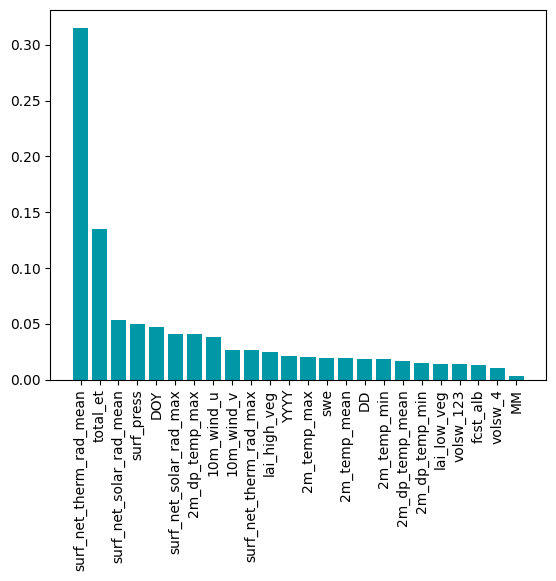

In [21]:
plot_sk_feature_importance(regressor_rf, X_test)

### XGBoost

#### Training

In [22]:
# Create a Random Forest Regressor
regressor_xgb = XGBRegressor(n_estimators=10)

In [23]:
regressor_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Evaluation

In [24]:
# Make predictions on the test data
y_pred_xgb = regressor_xgb.predict(X_test)

In [25]:
# Compute the evaluation metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_dict["xgb"] = math.sqrt(mse_xgb)

In [26]:
print("MSE: ", mse_xgb)
print("RMSE: ", math.sqrt(mse_xgb))

MSE:  16.242574053203903
RMSE:  4.0302076935567355


#### Feature Importance

[0.00537936 0.01884827 0.00821508 0.03057036 0.00870552 0.015998
 0.01378277 0.03908429 0.00272292 0.0257287  0.02763156 0.0188587
 0.01304157 0.10600888 0.0331568  0.02678169 0.05515712 0.03839786
 0.01824693 0.33347005 0.04075289 0.09342579 0.01710685 0.00892801]


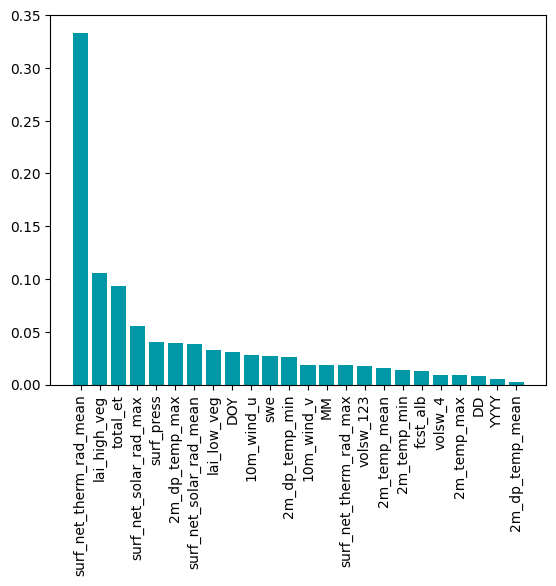

In [27]:
plot_sk_feature_importance(regressor_xgb, X_test)

### Linear Regression

#### Training

In [28]:
# Create a Random Forest Regressor
linr = LinearRegression()

In [29]:
linr.fit(X_train, y_train)

LinearRegression()

#### Evaluation

In [30]:
# Make predictions on the test data
y_pred_linr = linr.predict(X_test)

In [31]:
# Compute the evaluation metrics
mse_linr = mean_squared_error(y_test, y_pred_linr)
rmse_dict["linr"] = math.sqrt(mse_linr)

In [32]:
print("MSE: ", mse_linr)
print("RMSE: ", math.sqrt(mse_linr))

MSE:  24.208573137884603
RMSE:  4.920220842389557


#### Feature Importance

[-5.12846597e-03  2.55433832e+01  8.44218488e-01 -8.46545234e-01
 -2.00038895e-01 -6.68094594e-01  2.95434259e-01  4.87785040e-01
  6.19744583e-01 -3.84326560e-01  1.94662617e-01 -1.59605843e-01
 -1.01150984e+00  6.51696913e-02 -1.47548942e-01  1.95174685e-03
  5.55104377e-03 -5.19084057e-02 -2.41276652e-02 -4.01870959e-02
 -2.15964128e-04  2.36788885e+00  2.66175520e+00 -5.85150887e+00]


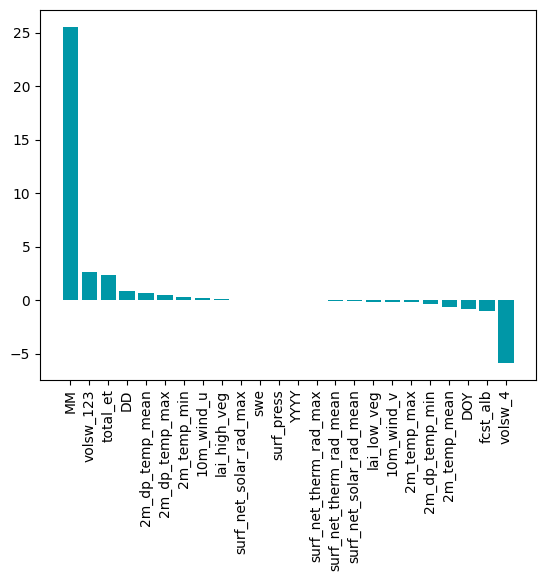

In [33]:
plot_sk_feature_importance(linr, X_test)

### Linear Support Vector Regression (LSVR)

#### Training

In [34]:
# Create a Random Forest Regressor
lsvr = LinearSVR(max_iter=100, verbose=1)

In [35]:
lsvr.fit(X_train, y_train)

[LibLinear]..........
optimization finished, #iter = 100

Using -s 11 may be faster

Objective value = -0.323780
nSV = 997080


Liblinear failed to converge, increase the number of iterations.


LinearSVR(max_iter=100, verbose=1)

#### Evaluation

In [36]:
# Make predictions on the test data
y_pred_lsvr = lsvr.predict(X_test)

In [37]:
# Compute the evaluation metrics
mse_lsvr = mean_squared_error(y_test, y_pred_lsvr)
rmse_dict["lsvr"] = math.sqrt(mse_lsvr)

In [38]:
print("MSE: ", mse_lsvr)
print("RMSE: ", math.sqrt(mse_lsvr))

MSE:  90.10770756438926
RMSE:  9.492507970204148


#### Feature Importance

[ 1.33997740e-02 -4.28633954e-05  1.42931691e-03 -4.92404562e-03
  1.71152132e-02  2.54006947e-02  3.30480288e-02  4.54390459e-02
  4.13671670e-02  3.63583970e-02  9.34521703e-03 -4.16593794e-03
 -4.02268244e-04  4.79683405e-03  8.39512159e-04 -1.70655478e-03
  4.47172964e-03 -1.36564480e-02 -5.75003382e-02 -8.34049764e-02
 -6.92264093e-05  8.56490126e-03 -3.00849713e-05 -4.40515654e-05]


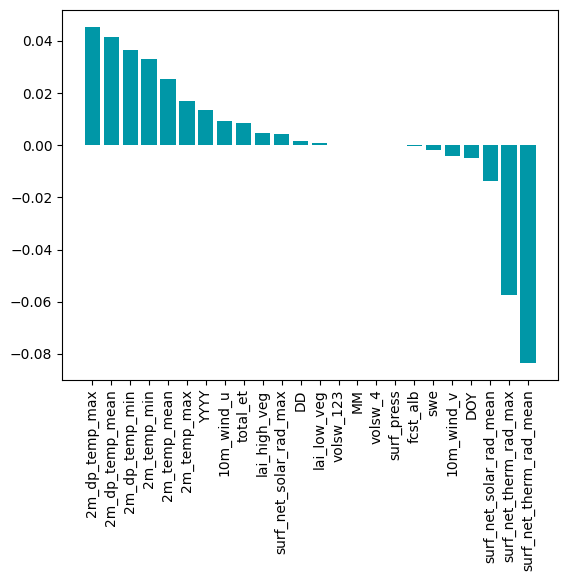

In [39]:
plot_sk_feature_importance(lsvr, X_test)

## Best Model

In [40]:
model_df = pd.DataFrame(list(zip(rmse_dict.keys(), list(map(lambda x: round(x, 3), list(rmse_dict.values()))))), columns=["model", "rmse"])

In [41]:
print("Comparison of all models:")
model_df

Comparison of all models:


,model,rmse
0,nn,3.275
1,dnn,3.629
2,rf,2.138
3,xgb,4.030
4,linr,4.920
5,lsvr,9.493


In [42]:
print("Best performing model is:")
model_df[model_df.rmse == model_df.rmse.min()]

Best performing model is:


,model,rmse
2,rf,2.138


[Text(0, 0, '3.275'),
 Text(0, 0, '3.629'),
 Text(0, 0, '2.138'),
 Text(0, 0, '4.03'),
 Text(0, 0, '4.92'),
 Text(0, 0, '9.493')]

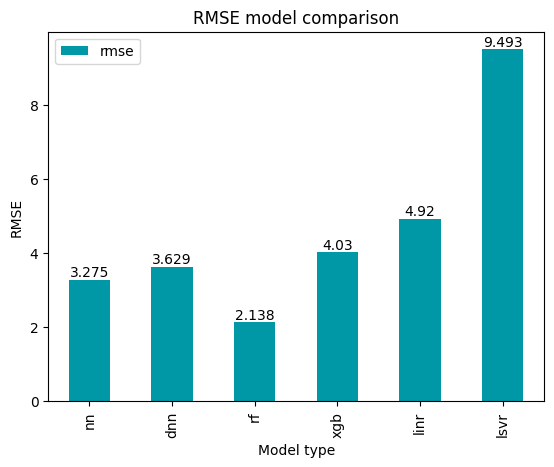

In [43]:
ax = model_df.plot.bar(
    x = "model",
    xlabel = "Model type",
    ylabel = "RMSE",    
    title = "RMSE model comparison",
    color = "#0097a7"
)

ax.bar_label(ax.containers[0])

### Hyperparamtet Tuning

Tuning RF Paramters

In [44]:
param_grid = {
    'n_estimators': [5, 7, 10, 12],
    'max_depth': [2, 5, 7, 12, None],
    'bootstrap': [True, False]
}

In [45]:
opt_model = RandomizedSearchCV(
    estimator = RandomForestRegressor(random_state = SEED), 
    param_distributions = param_grid
)

In [46]:
opt_model.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(random_state=345),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 5, 7, 12, None],
                                        'n_estimators': [5, 7, 10, 12]})

#### Evaluation of best Model

In [47]:
opt_y_preds = opt_model.predict(X_test)

In [48]:
# Compute the evaluation metrics
mse_opt_model = mean_squared_error(y_test, opt_y_preds)
rmse_dict["opt_rf"] = math.sqrt(mse_opt_model)

In [49]:
print(rmse_dict["opt_rf"])

2.2318046400396616


In [50]:
opt_model.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': 1.0,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 345,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(random_state=345),
 'n_iter': 10,
 'n_jobs': None,
 'param_distributions': {'n_estimators': [5, 7, 10, 12],
  'max_depth': [2, 5, 7, 12, None],
  'bootstrap': [True, False]},
 'pre_dispatch': '2*n_jobs',
 'random_state': None,
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}